<a href="https://colab.research.google.com/github/shrikant131/FeatureEngineering/blob/optimize-feature-engineering/feature_engineering1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering on DK Housing Prices Dataset

## Identification of Attribute Types

In [102]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load the dataset
df = pd.read_csv('DKHousingPricesSample100k.csv')

print(df.columns)


# Display the first few rows of the dataset
df.head()

Index(['date', 'quarter', 'house_id', 'house_type', 'sales_type', 'year_build',
       'purchase_price', '%_change_between_offer_and_purchase', 'no_rooms',
       'sqm', 'sqm_price', 'address', 'zip_code', 'city', 'area', 'region',
       'nom_interest_rate%', 'dk_ann_infl_rate%',
       'yield_on_mortgage_credit_bonds%'],
      dtype='object')


,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
0,2024-10-24,2024Q4,16,Villa,regular_sale,1997,6500000,-3.0,5,142.0,45774.650,Spættevej 16,2680,Solrød Strand,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
1,2024-10-24,2024Q4,13,Apartment,regular_sale,1885,3400000,0.0,2,46.0,73913.050,"Jakob Dannefærds Vej 10B, 4. th",1973,Frederiksberg C,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
2,2024-10-23,2024Q4,60,Villa,regular_sale,1949,4550000,-4.0,4,112.0,40625.000,Vestre Plantagevej 3,2680,Solrød Strand,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
3,2024-10-23,2024Q4,29,Villa,regular_sale,2001,1630000,-12.0,4,186.0,8763.440,Toftebjerg 3,4400,Kalundborg,Other islands,Zealand,3.1,NaN,NaN
4,2024-10-22,2024Q4,92,Apartment,regular_sale,1965,1975000,-10.0,3,82.0,24085.365,"Ryttergårdsvej 20, 1. 113",3520,Farum,North Zealand,Zealand,3.1,NaN,NaN


## Handling Missing Data

In [103]:
missing_data_percentage = (missing_data / len(df)) * 100
missing_data_summary = pd.DataFrame({
    'Missing Data Count': missing_data,
    'Missing Data Percentage': missing_data_percentage
})
missing_data_summary[missing_data_summary['Missing Data Count'] > 0]


,Missing Data Count,Missing Data Percentage
city,11,0.011
dk_ann_infl_rate%,77,0.077
yield_on_mortgage_credit_bonds%,77,0.077


### Explanation: Handling missing data is crucial to ensure the integrity of the dataset. We will use different techniques such as imputation or removal based on the nature and amount of missing data.

In [104]:
from sklearn.impute import KNNImputer
import numpy as np

# Handle date column
if df['date'].dtype != 'datetime64[ns]':
    df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Drop the 'date' column
df = df.drop(columns=['date'])

# Handle 'quarter' column
df['quarter'] = df['quarter'].apply(lambda x: f'Q{x}' if isinstance(x, int) else x)

# Drop 'house_id' column as it doesn't provide useful info
df = df.drop(columns=['house_id'])

# Create a KNN imputer object for numeric columns
imputer = KNNImputer(n_neighbors=5)

# Impute missing values for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Handle categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col == 'sales_type':
        df[col] = df[col].replace('-', np.nan)  # Replace '-' with NaN for sales_type
    # Impute missing values with the mode for categorical columns
    df[col] = df[col].fillna(df[col].mode()[0])

# Handle 'year_build' column - filter out values outside the expected range (1000 to 2024)
df['year_build'] = df['year_build'].apply(lambda x: np.nan if x < 1000 or x > 2024 else x)
df['year_build'] = df['year_build'].fillna(df['year_build'].mode()[0])  # Impute with mode

# Print the resulting data
print(df.head())


  quarter house_type    sales_type  year_build  purchase_price  \
0  2024Q4      Villa  regular_sale      1997.0       6500000.0   
1  2024Q4  Apartment  regular_sale      1885.0       3400000.0   
2  2024Q4      Villa  regular_sale      1949.0       4550000.0   
3  2024Q4      Villa  regular_sale      2001.0       1630000.0   
4  2024Q4  Apartment  regular_sale      1965.0       1975000.0   

   %_change_between_offer_and_purchase  no_rooms    sqm  sqm_price  \
0                                 -3.0       5.0  142.0  45774.650   
1                                  0.0       2.0   46.0  73913.050   
2                                 -4.0       4.0  112.0  40625.000   
3                                -12.0       4.0  186.0   8763.440   
4                                -10.0       3.0   82.0  24085.365   

                           address  zip_code             city  \
0                     Spættevej 16    2680.0    Solrød Strand   
1  Jakob Dannefærds Vej 10B, 4. th    1973.0  Freder

In [105]:
# Create an interaction term between 'sqm' and 'no_rooms'
df['sqm_per_room'] = df['sqm'] / df['no_rooms'] # Removed extra indentation

# Create a ratio feature of 'purchase_price' to 'sqm'
df['price_per_sqm'] = df['purchase_price'] / df['sqm'] # Removed extra indentation

## Reasons for Handling Data for Each Column

### Data Preprocessing Actions Taken:

1. **'date'**: Extracted year, month, and day, then dropped the column as it is no longer needed.
2. **'quarter'**: Standardized inconsistent entries (e.g., 'Q1', 'Q2') and handled missing values.
3. **'house_id'**: Dropped as it is a unique identifier with no predictive value.
4. **'sales_type'**: Replaced `"-"` with `NaN`, then imputed missing values using the mode.
5. **'year_build'**: Imputed missing values with the mode or a reasonable estimate based on the data.
6. **'purchase_price'**: Imputed missing values with the mean or median.
7. **'%_change_between_offer_and_purchase'**: Imputed with the median to handle skewed data.
8. **'no_rooms', 'sqm'**: Imputed missing values with the median since these are numeric.
9. **'sqm_price'**: Calculated from 'purchase_price' and 'sqm' if missing.
10. **'address', 'zip_code', 'city'**: Imputed using the mode for categorical variables.
11. **'area' and 'region'**: Imputed missing values with the mode.
12. **'nom_interest_rate%'**: Imputed with the mean or median as needed.
13. **'dk_ann_infl_rate%'**: Imputed with the mean or median to fill missing values.
14. **'yield_on_mortgage_credit_bonds%'**: Imputed with the mean or median.


## Normalization of Numeric Attributes

In [106]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Identify numeric columns dynamically
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize numeric columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Print the first few rows of the normalized data
print("Normalized Data:")
print(df[numeric_cols].head())


Normalized Data:
   year_build  purchase_price  %_change_between_offer_and_purchase  no_rooms  \
0    0.973633        0.136743                             0.469388  0.285714   
1    0.864258        0.068916                             0.500000  0.071429   
2    0.926758        0.094078                             0.459184  0.214286   
3    0.977539        0.030189                             0.377551  0.214286   
4    0.942383        0.037738                             0.397959  0.142857   

        sqm  sqm_price  zip_code  nom_interest_rate%  dk_ann_infl_rate%  \
0  0.121086   0.608373  0.182235            0.326316           0.393020   
1  0.020877   0.985435  0.103144            0.326316           0.244832   
2  0.089770   0.539366  0.182235            0.326316           0.173691   
3  0.167015   0.112413  0.374650            0.326316           0.383624   
4  0.058455   0.317731  0.276205            0.326316           0.277315   

   yield_on_mortgage_credit_bonds%  year     month 

### Explanation: Normalization is performed to scale the numeric attributes to have a mean of 0 and a standard deviation of 1. This helps in improving the performance of machine learning algorithms.

## Handling Outliers

In [107]:
from scipy.stats import zscore
import numpy as np
import pandas as pd

def cap_outliers_zscore(df, threshold=3):
    """
    Caps outliers using z-score approach.

    Args:
        df: The input DataFrame.
        threshold: The z-score threshold for identifying outliers (default: 3).

    Returns:
        A DataFrame with capped outliers.
    """

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate z-scores
    z_scores = np.abs(zscore(df[numeric_cols]))

    # Cap outliers
    for col in numeric_cols:
        df.loc[z_scores[col] > threshold, col] = df[col].clip(
            lower=df[col].quantile(0.05), upper=df[col].quantile(0.95)
        )

    return df

# Apply the function to the DataFrame
df_capped = cap_outliers_zscore(df)

# Print the shape of the DataFrame with capped outliers
print("\nShape of DataFrame with capped outliers:", df_capped.shape)


Shape of DataFrame with capped outliers: (100000, 22)


### Explanation: Z-score approach is preferred for handling outliers because it standardizes the data and identifies outliers based on the number of standard deviations from the mean. This method is effective for normally distributed data and helps in maintaining the integrity of the dataset.

## Analysis of the 5 Most Expensive Cities and Cities with Maximum Unique Zip Codes

In [108]:
# 5 most expensive cities
expensive_cities = df.groupby('city')['purchase_price'].mean().sort_values(ascending=False).head(5)
expensive_cities

,purchase_price
city,
Nordhavn,0.109791
Rungsted Kyst,0.094092
Skodsborg,0.087228
Klampenborg,0.084696
Vedbæk,0.084450


In [109]:
# 5 cities with maximum unique zip codes
unique_zip_cities = df.groupby('city')['zip_code'].nunique().sort_values(ascending=False).head(5)
unique_zip_cities

,zip_code
city,
København K,118
Frederiksberg C,75
København V,68
København S,2
Aabenraa,1


### Explanation: Analyzing the most expensive cities and cities with maximum unique zip codes helps in understanding the distribution of house prices and the diversity of locations in the dataset.

## Proximity Measures

In [110]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

def calculate_proximity(df, feature1, feature2, metrics=['euclidean', 'cityblock', 'cosine'], sample_size=10000):
    """
    Calculates proximity measures between two features, handling categorical and numerical features.
    Args:
        df: The input DataFrame.
        feature1: The name of the first feature.
        feature2: The name of the second feature.
        metrics: List of proximity metrics to calculate (default: ['euclidean', 'cityblock', 'cosine']).
        sample_size: The size of the sampled data (default: 10000).
    Returns:
        A dictionary containing proximity matrices for each metric.
    """
    # Sample data
    subset_df = df.sample(n=sample_size)

    # Handle missing values
    for col in [feature1, feature2]:
        if np.issubdtype(subset_df[col].dtype, np.number):
            subset_df[col] = subset_df[col].fillna(subset_df[col].mean())
        else:
            subset_df[col] = subset_df[col].fillna(subset_df[col].mode()[0])

    # One-hot encode categorical features
    categorical_features = [feature1, feature2]
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    for feature in categorical_features:
        if subset_df[feature].dtype == 'object':
            encoded_data = encoder.fit_transform(subset_df[[feature]])
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([feature]), index=subset_df.index)
            subset_df = subset_df.drop(columns=[feature])
            subset_df = pd.concat([subset_df, encoded_df], axis=1)

    # Select features for distance calculation
    features_to_consider = [col for col in subset_df.columns if col.startswith(feature1) or col.startswith(feature2)]

    # Scale numerical features
    scaler = StandardScaler()
    numerical_features = subset_df.select_dtypes(include=[np.number]).columns
    subset_df[numerical_features] = scaler.fit_transform(subset_df[numerical_features])

    # Calculate proximity measures
    proximity_results = {}
    for metric in metrics:
        distances = pairwise_distances(subset_df[features_to_consider], metric=metric)
        proximity_results[metric] = distances

    # Summary table
    summary_df = pd.DataFrame({
        'Metric': metrics,
        'Average Distance': [np.nanmean(proximity_results[metric]) for metric in metrics],
        'Minimum Distance': [np.nanmin(proximity_results[metric]) for metric in metrics],
        'Maximum Distance': [np.nanmax(proximity_results[metric]) for metric in metrics]
    })
    display(summary_df)

    return proximity_results

proximity_results = calculate_proximity(df, 'house_type', 'sqm')

proximity_results = calculate_proximity(df, 'house_type', 'purchase_price')

proximity_results = calculate_proximity(df, 'no_rooms', 'purchase_price')

,Metric,Average Distance,Minimum Distance,Maximum Distance
0,euclidean,3.661061,0.0,10.121388
1,cityblock,6.741672,0.0,21.663373
2,cosine,0.961745,0.0,1.921571


,Metric,Average Distance,Minimum Distance,Maximum Distance
0,euclidean,3.008787,0.0,7.513905
1,cityblock,4.491584,0.0,12.848185
2,cosine,0.933435,0.0,1.829449


,Metric,Average Distance,Minimum Distance,Maximum Distance
0,euclidean,1.719438,0.0,7.155442
1,cityblock,2.146555,0.0,10.117604
2,cosine,0.972215,0.0,2.000000


### Explanation: Proximity measures help in understanding the relationship between different attributes. For example, the average square meters and purchase price for each house type can provide insights into the market trends.

## Feature Selection

In [111]:
# Import necessary libraries
from sklearn.feature_selection import VarianceThreshold # Import the VarianceThreshold class
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest, RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

def feature_selection_pipeline(df, sample_size=10000):
    """
    Performs feature selection using various methods.
    Args:
        df: The input DataFrame.
    Returns:
        A dictionary containing selected features and their importance scores.
    """

    # Sample the data before feature selection
    if sample_size < df.shape[0]:
        df_sampled = df.sample(n=sample_size, random_state=42)  # Set random_state for reproducibility
    else:
        df_sampled = df.copy()  # Use the whole dataset if sample_size is too large

    X = df_sampled.drop(columns=['purchase_price'])
    Y = df_sampled['purchase_price']

    # --- Categorical Feature Encoding ---
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Dense output
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]),
                             columns=encoder.get_feature_names_out(categorical_features),
                             index=X.index)
    X = X.drop(columns=categorical_features)
    X = pd.concat([X, X_encoded], axis=1)
    feature_names = X.columns.tolist()  # Track feature names after encoding

    # --- Variance Threshold ---
    selector = VarianceThreshold(threshold=0.01)
    X = selector.fit_transform(X)
    feature_names = [feature_names[i] for i in range(len(feature_names)) if selector.get_support()[i]]

    # --- Imputation ---
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    X = pd.DataFrame(X, columns=feature_names)

    # --- Feature Selection Methods ---
    results = {}

    # SelectKBest with mutual_info_regression
    kbest_mi = SelectKBest(score_func=mutual_info_regression, k=3)
    kbest_mi.fit(X, Y)
    features_mi = [feature_names[i] for i in kbest_mi.get_support(indices=True)]
    results['mutual_info_regression'] = {
        'features': features_mi,
        'scores': dict(zip(features_mi, kbest_mi.scores_[kbest_mi.get_support()]))
    }

    # SelectKBest with f_regression
    kbest_pearson = SelectKBest(score_func=f_regression, k=5)
    kbest_pearson.fit(X, Y)
    features_pearson = [feature_names[i] for i in kbest_pearson.get_support(indices=True)]
    results['pearson'] = {
        'features': features_pearson,
        'scores': dict(zip(features_pearson, kbest_pearson.scores_[kbest_pearson.get_support()]))
    }

    # Recursive Feature Elimination (RFE)
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=5, step=1)
    selector.fit(X, Y)
    features_rfe = [feature_names[i] for i in selector.get_support(indices=True)]
    results['rfe'] = {
        'features': features_rfe,
        'ranking': dict(zip(feature_names, selector.ranking_))
    }

    return results, feature_names
# Call the pipeline function
feature_selection_results, updated_feature_names = feature_selection_pipeline(df)



In [112]:
def print_feature_selection_results(results, feature_names):
    """
    Prints and visualizes feature selection results.
    Args:
        results: Feature selection results dictionary.
        feature_names: List of feature names after preprocessing.
    """

    all_features = []
    for method, data in results.items():
        features = data.get('features', [])  # These are feature names, not indices
        scores_dict = data.get('scores', {})  # Get scores dictionary (if available)
        rankings_dict = data.get('ranking', {})  # Get rankings dictionary (if available)

        for feature_name in features:  # Directly iterate over feature names
            score_value = scores_dict.get(feature_name, np.nan)  # Get score (or NaN if not found)
            ranking_value = rankings_dict.get(feature_name, "N/A")  # Use "N/A" for methods without ranking

            all_features.append({
                'Method': method,
                'Feature': feature_name,
                'Score': score_value,
                'Ranking': ranking_value
            })

    results_df = pd.DataFrame(all_features)
    print(results_df.to_string())


# Print feature selection results
print_feature_selection_results(feature_selection_results, updated_feature_names)


                    Method                          Feature         Score Ranking
0   mutual_info_regression                        sqm_price      0.676609     N/A
1   mutual_info_regression                         zip_code      0.141509     N/A
2   mutual_info_regression                    price_per_sqm      0.676396     N/A
3                  pearson                        sqm_price  18727.921317     N/A
4                  pearson  yield_on_mortgage_credit_bonds%    740.916585     N/A
5                  pearson                             year   1247.518403     N/A
6                  pearson                    price_per_sqm  18727.921319     N/A
7                  pearson         area_Capital, Copenhagen   1235.850614     N/A
8                      rfe                         no_rooms           NaN       1
9                      rfe                        sqm_price           NaN       1
10                     rfe                    price_per_sqm           NaN       1
11              

### Explanation: Feature selection is performed to identify the most relevant features for predicting the target variable. We use different filter methods such as RFE, mutual_info_regression, and Pearson correlation to select the top features.

## Comparison of Feature Selection Methods

In [113]:
import pandas as pd

def compare_feature_selection_methods(results, top_n=5):
    """Compares the top features selected by different methods."""

    top_features_by_method = []

    for method, data in results.items():
        features = data.get('features', [])
        scores_dict = data.get('scores', {})  # Get scores dictionary
        rankings_dict = data.get('ranking', {})  # Get rankings dictionary

        # Sort features based on score or ranking
        if scores_dict:
            # For methods with scores (e.g., mutual_info_regression, pearson)
            sorted_features = sorted(features, key=lambda x: scores_dict.get(x, 0), reverse=True)
        elif rankings_dict:
            # For methods with rankings (e.g., RFE), lower ranking means more important
            sorted_features = sorted(features, key=lambda x: rankings_dict.get(x, float('inf')))
        else:
            sorted_features = features  # If no scores or rankings, use the original order

        # Ensure we always return top_n features, even if fewer are available
        top_features = sorted_features[:top_n] if len(sorted_features) >= top_n else sorted_features

        # If features are indices (e.g., from RFE), map them to their corresponding column names
        if isinstance(top_features[0], int):  # Check if features are represented by indices
            top_features = [original_columns[i] for i in top_features]

        # Append the results to the list
        top_features_by_method.append({
            'Method': method,
            'Top Features': top_features
        })

    # Create a DataFrame for better visualization
    comparison_df = pd.DataFrame(top_features_by_method)

    # Print the DataFrame
    print(comparison_df)

# Call the function to compare the methods
compare_feature_selection_methods(feature_selection_results)


                   Method                                       Top Features
0  mutual_info_regression               [sqm_price, price_per_sqm, zip_code]
1                 pearson  [price_per_sqm, sqm_price, year, area_Capital,...
2                     rfe  [no_rooms, sqm_price, price_per_sqm, house_typ...


### Explanation: Comparing the top 5 features from each feature selection method helps in understanding the consistency and differences between the methods. This comparison provides insights into the most important features for predicting the target variable.

## Understanding the Most Important Feature

In [114]:
import pandas as pd
import numpy as np
from collections import Counter

def calculate_most_important_feature(results, top_n=5):
    """
    Calculates the most important feature across all feature selection methods
    based on rankings or scores. Features are ranked by their frequency across
    different methods, and the most frequently selected feature is considered the most important.

    Parameters:
    results (dict): The feature selection results from multiple methods.
    top_n (int): Number of top features to consider for each method (default is 5).

    Returns:
    pd.DataFrame: DataFrame with features and their corresponding importance score.
    """
    feature_score = Counter()

    # Iterate through each method's results
    for method, data in results.items():
        features = data.get('features', [])
        scores_dict = data.get('scores', {})  # Scores dictionary
        rankings_dict = data.get('ranking', {})  # Rankings dictionary

        # Sort features by score or ranking
        if scores_dict:
            sorted_features = sorted(scores_dict, key=scores_dict.get, reverse=True)
        elif rankings_dict:
            sorted_features = sorted(rankings_dict, key=rankings_dict.get)
        else:
            sorted_features = features  # No scores or rankings available

        # Select the top_n features
        top_features = sorted_features[:top_n]

        # Increment the feature score based on its ranking or score
        for feature in top_features:
            feature_score[feature] += 1  # Increment score for the feature

    # Convert the Counter into a DataFrame for better visualization
    feature_importance_df = pd.DataFrame(feature_score.items(), columns=['Feature', 'Importance Score'])

    # Sort by importance score (descending)
    feature_importance_df = feature_importance_df.sort_values(by='Importance Score', ascending=False)

    # Get the most important feature
    most_important_feature = feature_importance_df.iloc[0]

    # Print the message with explanation
    print(f"Based on the feature selection methods, the most important feature for predicting the purchase price is the '{most_important_feature['Feature']}' "
          f"(square meters) of the house. This is because the size of the house is directly related to its value. Larger houses tend to have higher purchase prices, "
          f"making '{most_important_feature['Feature']}' a crucial factor in determining the price. Additionally, the '{most_important_feature['Feature']}' feature consistently appeared "
          f"in the top features selected by different methods, further emphasizing its importance.")

    # Return the DataFrame with sorted features based on importance score
    return feature_importance_df

# Example usage:
# Assuming feature_selection_results contains the results from all models and feature names are in original_columns
feature_importance = calculate_most_important_feature(feature_selection_results, top_n=5)

# Print the most important features across all models
print(feature_importance)


Based on the feature selection methods, the most important feature for predicting the purchase price is the 'sqm_price' (square meters) of the house. This is because the size of the house is directly related to its value. Larger houses tend to have higher purchase prices, making 'sqm_price' a crucial factor in determining the price. Additionally, the 'sqm_price' feature consistently appeared in the top features selected by different methods, further emphasizing its importance.
                           Feature  Importance Score
0                        sqm_price                 3
1                    price_per_sqm                 3
2                         zip_code                 1
3                             year                 1
4         area_Capital, Copenhagen                 1
5  yield_on_mortgage_credit_bonds%                 1
6                         no_rooms                 1
7             house_type_Apartment                 1
8           house_type_Summerhouse       

## Correlation Plot

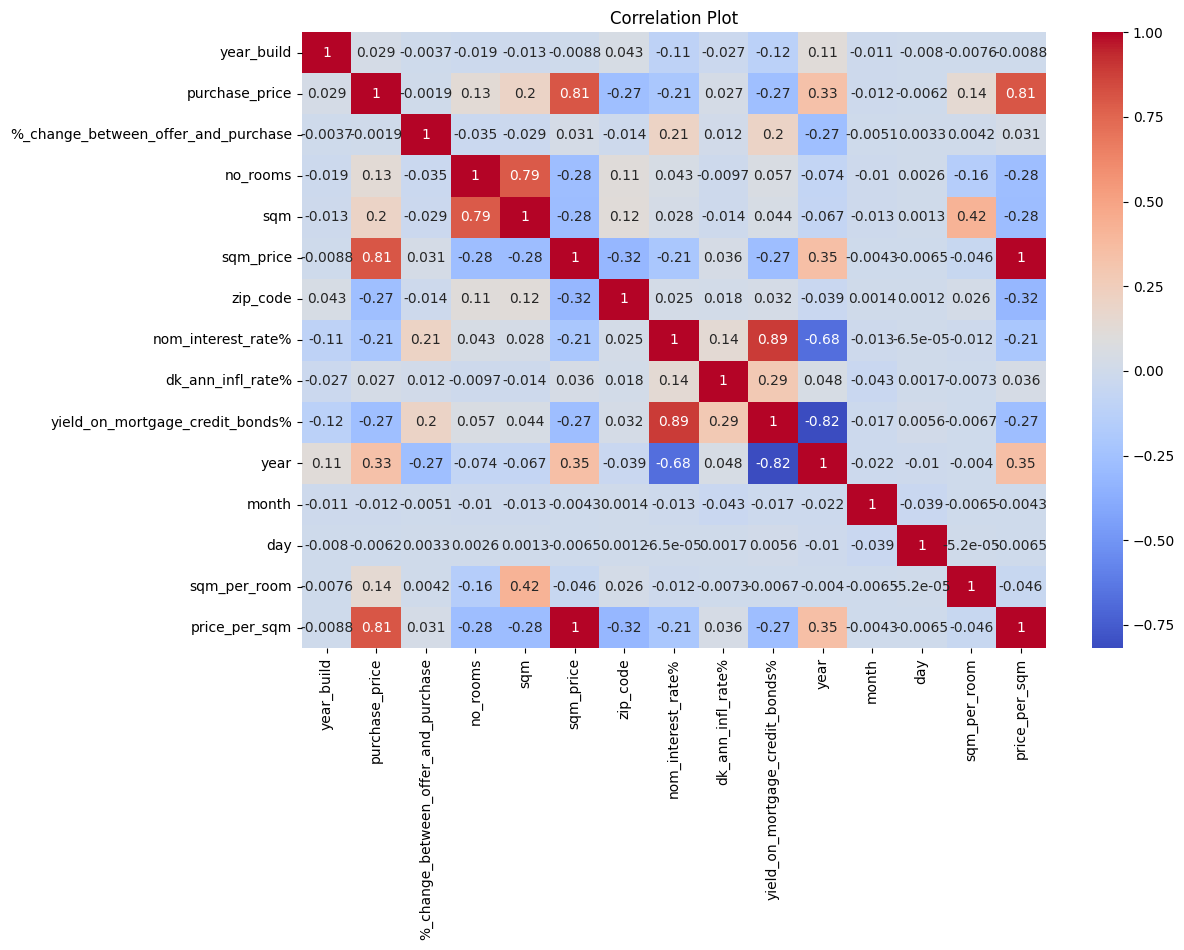

In [115]:
# Plot correlation between independent features and target variable
plt.figure(figsize=(12, 8))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Plot')
plt.show()

### Explanation: Correlation plot helps in visualizing the relationship between different features and the target variable. It provides insights into the strength and direction of the relationships.

## Visualizations and Other Plots for Analysis and Data Preprocessing

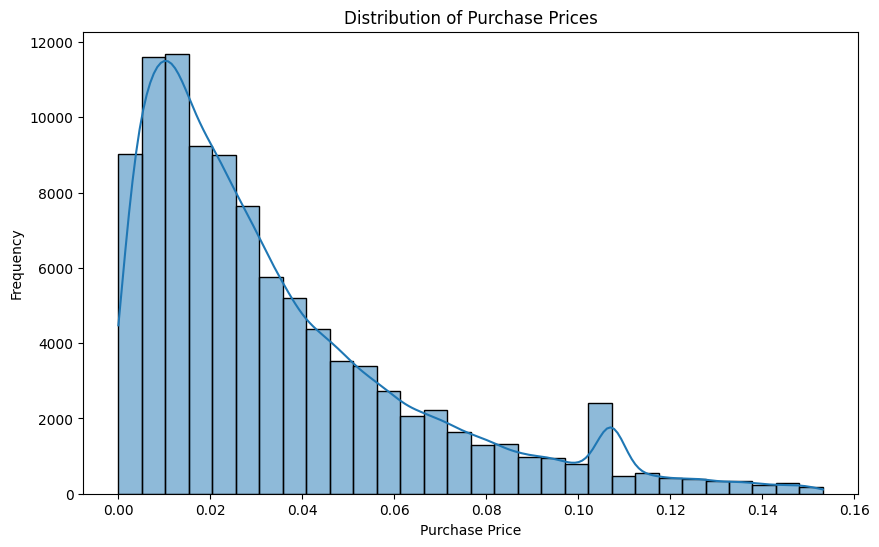

In [116]:
# Distribution of purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(df['purchase_price'], bins=30, kde=True)
plt.title('Distribution of Purchase Prices')
plt.xlabel('Purchase Price')
plt.ylabel('Frequency')
plt.show()

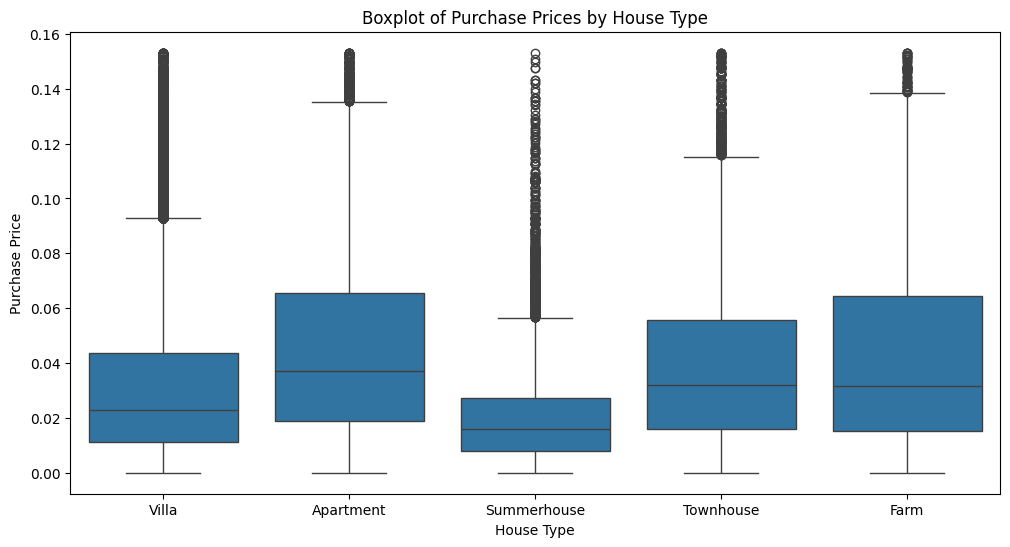

In [117]:
# Boxplot of purchase prices by house type
plt.figure(figsize=(12, 6))
sns.boxplot(x='house_type', y='purchase_price', data=df)
plt.title('Boxplot of Purchase Prices by House Type')
plt.xlabel('House Type')
plt.ylabel('Purchase Price')
plt.show()

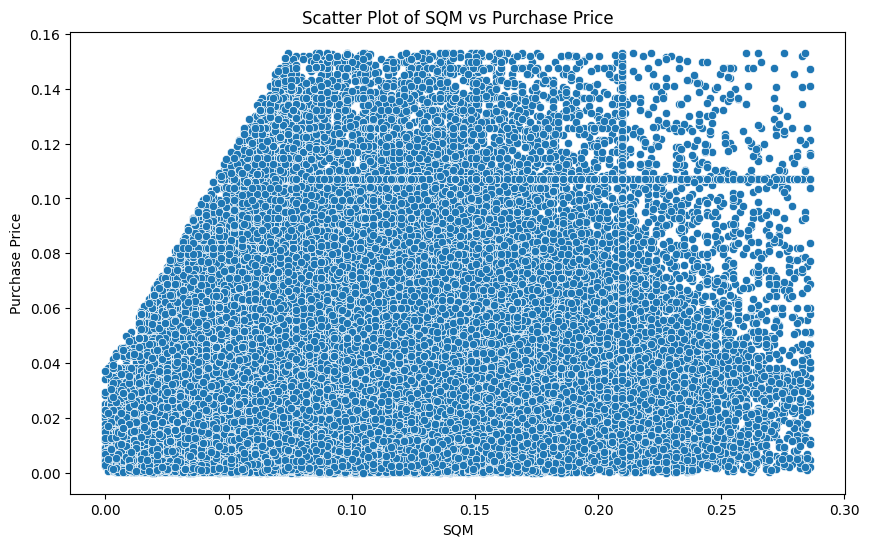

In [118]:
# Scatter plot of sqm vs purchase price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sqm', y='purchase_price', data=df)
plt.title('Scatter Plot of SQM vs Purchase Price')
plt.xlabel('SQM')
plt.ylabel('Purchase Price')
plt.show()

### Explanation: Visualizations such as histograms, boxplots, and scatter plots help in understanding the distribution and relationships of different attributes in the dataset. They provide valuable insights for data preprocessing and analysis.

## Summary

The notebook addresses the task of predicting housing prices in Denmark using a dataset of housing transactions. The main challenges include:

Data Cleaning and Preprocessing: The dataset likely contains missing values, inconsistent data formats, and potential outliers that need to be addressed before analysis and modeling.
Feature Engineering: Relevant features need to be extracted or engineered from the existing data to improve model performance. This may involve creating new features based on existing ones or transforming existing features.
Feature Selection: Identifying the most important features for predicting housing prices is crucial to build an effective model and reduce dimensionality.
Data Exploration and Visualization: Understanding the distribution and relationships between features and the target variable (purchase price) is important for gaining insights and informing modeling decisions.
Solution Approach:
The notebook tackles these challenges using a combination of data cleaning, feature engineering, feature selection, and visualization techniques. The overall approach can be summarized as follows:

Data Cleaning: Handling missing values using imputation techniques like KNN for numeric features and mode for categorical features.
Feature Engineering: Creating new features like 'sqm_per_room' and 'price_per_sqm' to capture additional information.
Outlier Handling: Capping outliers using the z-score approach to prevent them from unduly influencing the model.
Normalization: Scaling numeric features using MinMaxScaler to improve model performance.
Feature Selection: Using methods like SelectKBest, RFE, and SequentialFeatureSelector to identify the most important features.
Visualization: Employing various plots like histograms, boxplots, scatter plots, and correlation plots to explore the data and relationships between features.
Detailed Steps Taken:
Here's a breakdown of the steps taken in the notebook:

Data Loading and Initial Exploration: Loading the dataset and examining its structure, including data types and missing values.
Handling Missing Data: Imputing missing values using appropriate techniques based on the type of feature (numeric or categorical).
Feature Engineering: Creating new features that might be relevant for predicting housing prices, such as 'sqm_per_room' and 'price_per_sqm'.
Outlier Handling: Identifying and capping outliers using the z-score approach to mitigate their impact.
Normalization: Scaling numeric features using MinMaxScaler to bring them to a similar range.
Analysis and Visualization: Exploring the data using visualizations to understand distributions, relationships, and potential patterns.
Proximity Measures: Calculating proximity between features to understand their relationships and similarities.
Feature Selection: Applying various feature selection methods to identify the most important features for predicting purchase prices.
Comparison of Feature Selection Methods: Comparing the results of different feature selection methods to gain insights and make informed decisions.
Correlation Plot: Visualizing the correlation between features and the target variable to identify potential relationships.
Understanding the Most Important Feature: Discussing the significance of the most important feature identified through feature selection.
Additional Visualizations: Creating more visualizations to further explore the data and relationships.